<a href="https://colab.research.google.com/github/biditdas18/Automatic_Image_Captioning/blob/master/Image_caption.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    COLAB = True
    print("Note: using Google CoLab")
    %tensorflow_version 2.x
except:
    print("Note: not using Google CoLab")
    COLAB = False

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
Note: using Google CoLab


In [114]:
COLAB = True
!pwd

/content


In [115]:
if COLAB:
    root_captioning = "/content/drive/My Drive/captions"
else:
    root_captioning = "./data/captions"

## Making Necessary Imports

In [116]:
import os
import string
import glob
from tensorflow.keras.applications import MobileNet
import tensorflow.keras.applications.mobilenet  

from tensorflow.keras.applications.inception_v3 import InceptionV3
import tensorflow.keras.applications.inception_v3


from tqdm import tqdm
import tensorflow.keras.preprocessing.image
import pickle
from time import time
import numpy as np
from PIL import Image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import Input, layers
from tensorflow.keras import optimizers

from tensorflow.keras.models import Model

from tensorflow.keras.layers import add
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

START = "startseq"
STOP = "endseq"
EPOCHS = 10
USE_INCEPTION = True

In [117]:
## Time Elapsed
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m:>02}:{s:>05.2f}"

## Cleaning And Building Dataset From Flickr8k

In [118]:
null_punc = str.maketrans('','',string.punctuation)
lookup = dict()

with open(os.path.join(root_captioning,'Flickr8k_text','Flickr8k.token.txt'),'r') as fp:

  max_length = 0
  for line in fp.read().split('\n'):
    tok = line.split()
    if len(line) >= 2:
      id = tok[0].split('.')[0]
      desc = tok[1:]

      # Cleanup description
      desc = [word.lower() for word in desc]
      desc = [word.translate(null_punc) for word in desc]
      desc = [word for word in desc if len(word)>1]
      desc = [word for word in desc if word.isalpha()]
      max_length = max(max_length,len(desc))

      if id not in lookup:
        lookup[id] = []
      lookup[id].append(' '.join(desc))

lex = set()
for key in lookup:
  [lex.update(d.split()) for d in lookup[key]]

In [119]:
# Stats of data processed
print(len(lookup)) # How many unique words
print(len(lex)) # The dictionary
print(max_length) # Maximum length of a caption (in words)

8092
8763
32


In [120]:
# Load the Glove Embeddings
img = glob.glob(os.path.join(root_captioning,'Flickr8k_Dataset','Flicker8k_Dataset', '*.jpg'))
# Count of total number of images in the Dataset
len(img)

8095

In [121]:
train_images_path = os.path.join(root_captioning,'Flickr8k_text','Flickr_8k.trainImages.txt')
train_images = set(open(train_images_path,'r').read().split('\n'))
test_images_path = os.path.join(root_captioning,'Flickr8k_text','Flickr_8k.testImages.txt')
test_images = set(open(test_images_path, 'r').read().strip().split('\n'))

train_img = []
test_img = []

for i in img:
  f = os.path.split(i)[-1]
  if f in train_images:
    train_img.append(f)
  elif f in test_images:
    test_img.append(f)

In [122]:
# Display the size of the train and test sets
print(len(train_images))
print(len(test_images))

6001
1000


In [ ]:
lookup.items()

In [124]:
# Build the sequence
train_descriptions = {k:v for k,v in lookup.items() if f'{k}.jpg' in train_images}
for n,v in train_descriptions.items():
  for d in range(len(v)):
    v[d] = f'{START} {v[d]} {STOP}'
  

In [125]:
len(train_descriptions)

6000

## Choosing a Convolutional Neural Network For Weight Transfer

In [126]:
if USE_INCEPTION:
  encode_model = InceptionV3(weights='imagenet')
  encode_model = Model(encode_model.input, encode_model.layers[-2].output)
  WIDTH = 299
  HEIGHT = 299
  OUTPUT_DIM = 2048
  preprocess_input = tensorflow.keras.applications.inception_v3.preprocess_input
else:
  encode_model = MobileNet(weights='imagenet',include_top=False)
  WIDTH = 224
  HEIGHT = 224
  OUTPUT_DIM = 50176
  preprocess_input = tensorflow.keras.applications.mobilenet.preprocess_input

In [127]:
encode_model.summary()

Model: "functional_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d_282 (Conv2D)             (None, 149, 149, 32) 864         input_10[0][0]                   
__________________________________________________________________________________________________
batch_normalization_282 (BatchN (None, 149, 149, 32) 96          conv2d_282[0][0]                 
__________________________________________________________________________________________________
activation_282 (Activation)     (None, 149, 149, 32) 0           batch_normalization_282[0][0]    
______________________________________________________________________________________

## Creating The Training Set

In [128]:
# We encode the images in the dataset to create the training set. Later we will encode new images to present them for captioning

def encodeImage(img):
  # Resize all images to a standard size (specified bythe image encoding network)
  img = img.resize((WIDTH, HEIGHT), Image.ANTIALIAS)
  # Convert a PIL image to a numpy array
  x = tensorflow.keras.preprocessing.image.img_to_array(img)
  # Expand to 2D array
  x = np.expand_dims(x, axis=0)
  # Perform any preprocessing needed by InceptionV3 or others
  x = preprocess_input(x)
  # Call InceptionV3 (or other) to extract the smaller feature set for the image.
  x = encode_model.predict(x) # Get the encoding vector for the image
  # Shape to correct form to be accepted by LSTM captioning network.
  x = np.reshape(x, OUTPUT_DIM )
  return x

In [129]:
train_path = os.path.join(root_captioning,f'train{OUTPUT_DIM}.pkl')
if not os.path.exists(train_path):
  start = time()
  encoding_train = {}
  for id in tqdm(train_img):
    image_path = os.path.join(root_captioning,'Flickr8k_Dataset','Flicker8k_Dataset', id)
    img = tensorflow.keras.preprocessing.image.load_img(image_path, target_size=(HEIGHT, WIDTH))
    encoding_train[id] = encodeImage(img)
  with open(train_path, "wb") as fp:
    pickle.dump(encoding_train, fp)
  print(f"\nGenerating training set took: {hms_string(time()-start)}")
else:
  with open(train_path, "rb") as fp:
    encoding_train = pickle.load(fp)

In [130]:
test_path = os.path.join(root_captioning,f'test{OUTPUT_DIM}.pkl')
if not os.path.exists(test_path):
  start = time()
  encoding_test = {}
  for id in tqdm(test_img):
    image_path = os.path.join(root_captioning,'Flickr8k_Dataset','Flicker8k_Dataset', id)
    img = tensorflow.keras.preprocessing.image.load_img(image_path, target_size=(HEIGHT, WIDTH))
    encoding_test[id] = encodeImage(img)
  with open(test_path, "wb") as fp:
    pickle.dump(encoding_test, fp)
  print(f"\nGenerating testing set took: {hms_string(time()-start)}")
else:
  with open(test_path, "rb") as fp:
    encoding_test = pickle.load(fp)

In [131]:
# separate the captions that we will use for training
all_train_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        all_train_captions.append(cap)
len(all_train_captions)

30000

In [132]:
# Removing words with less frequent occurance i.e. less than 10 to prevent it from misleading the neural network
word_count_threshold = 10
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1

vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
print('preprocessed words %d ==> %d' % (len(word_counts), len(vocab)))


preprocessed words 7578 ==> 1651


In [133]:
# Create two lookup tables idxtoword that converts index numbers to actual words to index values
# and wordtoidx lookup table performs the opposite
idxtoword = {}
wordtoidx = {}

ix = 1
for w in vocab:
    wordtoidx[w] = ix
    idxtoword[ix] = w
    ix += 1
    
vocab_size = len(idxtoword) + 1 
vocab_size

1652

In [134]:
max_length +=2
print(max_length)

34


# Using Data Generator For Generating New Data

In [135]:
def data_generator(descriptions, photos, wordtoidx, max_length, num_photos_per_batch):
  # x1 - Training data for photos
  # x2 - The caption that goes with each photo
  # y - The predicted rest of the caption
  x1, x2, y = [], [], []
  n=0
  while True:
    for key, desc_list in descriptions.items():
      n+=1
      photo = photos[key+'.jpg']
      # Each photo has 5 descriptions
      for desc in desc_list:
        # Convert each word into a list of sequences.
        seq = [wordtoidx[word] for word in desc.split(' ') if word in wordtoidx]
        # Generate a training case for every possible sequence and outcome
        for i in range(1, len(seq)):
          in_seq, out_seq = seq[:i], seq[i]
          in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
          out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
          x1.append(photo)
          x2.append(in_seq)
          y.append(out_seq)
      if n==num_photos_per_batch:
        yield ([np.array(x1), np.array(x2)], np.array(y))
        x1, x2, y = [], [], []
        n=0

# Load Glove Embedding

In [136]:
glove_dir = os.path.join(root_captioning,'glove.6B')
embeddings_index = {} 
f = open(os.path.join(glove_dir, 'glove.6B.200d.txt'), encoding="utf-8")

for line in tqdm(f):
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

f.close()
print(f'Found {len(embeddings_index)} word vectors.')

400000it [00:23, 17059.36it/s]

Found 400000 word vectors.


# Building The Neural Network

In [137]:
embedding_dim = 200   # As our Glove Embedding embeddes each word with 200-d vector

# Get 200-dim dense vector for each of the 1652 words in our vocabulary
embedding_matrix = np.zeros((vocab_size, embedding_dim))  #(1652,200)

for word, i in wordtoidx.items():
    #if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector

In [138]:
embedding_matrix.shape

(1652, 200)

In [139]:
inputs1 = Input(shape=(OUTPUT_DIM,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)  # vocab_size = 1652
caption_model = Model(inputs=[inputs1, inputs2], outputs=outputs)

In [140]:
embedding_dim

200

In [141]:
caption_model.summary()

Model: "functional_15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 34)]         0                                            
__________________________________________________________________________________________________
input_11 (InputLayer)           [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 34, 200)      330400      input_12[0][0]                   
__________________________________________________________________________________________________
dropout_6 (Dropout)             (None, 2048)         0           input_11[0][0]                   
______________________________________________________________________________________

In [142]:
caption_model.layers[2].set_weights([embedding_matrix])
caption_model.layers[2].trainable = False
caption_model.compile(loss='categorical_crossentropy', optimizer='adam')

# Training The Neural Network

In [143]:
number_pics_per_batch = 3
steps = len(train_descriptions)//number_pics_per_batch

In [144]:
model_path = os.path.join(root_captioning,f'caption-model.hdf5')
if not os.path.exists(model_path):
  for i in tqdm(range(EPOCHS*2)):
      generator = data_generator(train_descriptions, encoding_train, wordtoidx, max_length, number_pics_per_batch)
      caption_model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)

  caption_model.optimizer.lr = 1e-4
  number_pics_per_batch = 6
  steps = len(train_descriptions)//number_pics_per_batch

  for i in range(EPOCHS):
      generator = data_generator(train_descriptions, encoding_train, wordtoidx, max_length, number_pics_per_batch)
      caption_model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)  
  caption_model.save_weights(model_path)
  print(f"\Training took: {hms_string(time()-start)}")
else:
  caption_model.load_weights(model_path)

# Generating Captions

In [145]:

def generateCaption(photo):
    in_text = START
    for i in range(max_length):
        sequence = [wordtoidx[w] for w in in_text.split() if w in wordtoidx]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = caption_model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = idxtoword[yhat]
        in_text += ' ' + word
        if word == STOP:
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

# Evaluating Performace on test data From Flicker8k Dataset

/content/drive/My Drive/captions/Flickr8k_Dataset/Flicker8k_Dataset/3541474181_489f19fae7.jpg


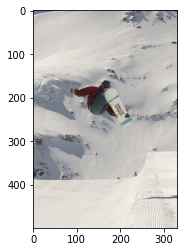

Caption: man in red jacket is snowboarding in the snow
_____________________________________
/content/drive/My Drive/captions/Flickr8k_Dataset/Flicker8k_Dataset/106490881_5a2dd9b7bd.jpg


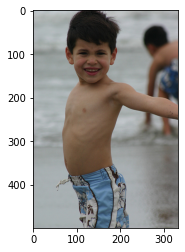

Caption: young boy in blue shorts is splashing in the water
_____________________________________
/content/drive/My Drive/captions/Flickr8k_Dataset/Flicker8k_Dataset/3567061016_62768dcce1.jpg


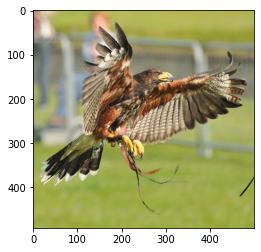

Caption: the little boy is playing with the fire
_____________________________________
/content/drive/My Drive/captions/Flickr8k_Dataset/Flicker8k_Dataset/2844018783_524b08e5aa.jpg


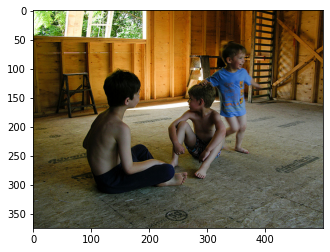

Caption: two children are playing in pile of leaves
_____________________________________
/content/drive/My Drive/captions/Flickr8k_Dataset/Flicker8k_Dataset/488408004_a1e26d4886.jpg


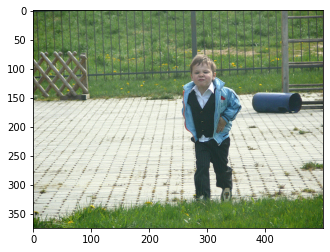

Caption: man in black shirt and jeans stands on the sidewalk
_____________________________________
/content/drive/My Drive/captions/Flickr8k_Dataset/Flicker8k_Dataset/3591462960_86045906bd.jpg


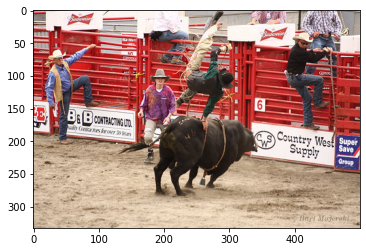

Caption: two dogs are playing with each other on the grass
_____________________________________
/content/drive/My Drive/captions/Flickr8k_Dataset/Flicker8k_Dataset/2542662402_d781dd7f7c.jpg


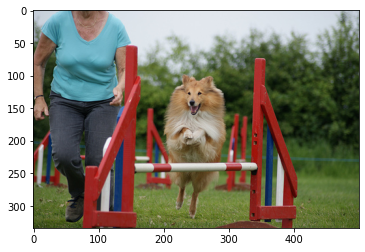

Caption: dog jumps over bar
_____________________________________
/content/drive/My Drive/captions/Flickr8k_Dataset/Flicker8k_Dataset/150387174_24825cf871.jpg


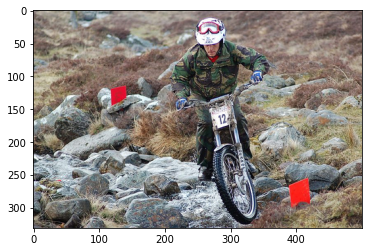

Caption: man in blue shirt and blue helmet is riding bike on rocky path
_____________________________________
/content/drive/My Drive/captions/Flickr8k_Dataset/Flicker8k_Dataset/3429956016_3c7e3096c2.jpg


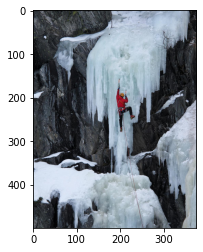

Caption: man in red jacket is sitting on rock next to large rock
_____________________________________
/content/drive/My Drive/captions/Flickr8k_Dataset/Flicker8k_Dataset/3053743109_a2d780c0d2.jpg


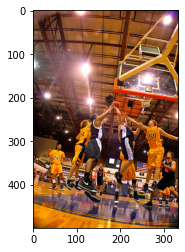

Caption: two men in gym
_____________________________________


In [146]:
for z in range(10):
  pic = list(encoding_test.keys())[z]
  image = encoding_test[pic].reshape((1,OUTPUT_DIM))
  print(os.path.join(root_captioning,'Flickr8k_Dataset','Flicker8k_Dataset', pic))
  im=plt.imread(os.path.join(root_captioning,'Flickr8k_Dataset','Flicker8k_Dataset', pic))
  plt.imshow(im)
  plt.show()
  print("Caption:",generateCaption(image))
  print("_____________________________________")

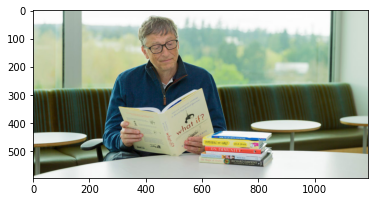

(1, 2048)
Caption: man in black shirt and tie is sitting in front of an art gallery
_____________________________________


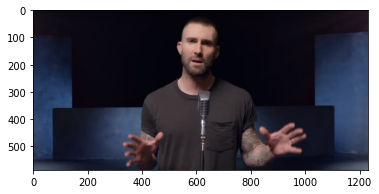

(1, 2048)
Caption: man and woman are sitting on bench
_____________________________________


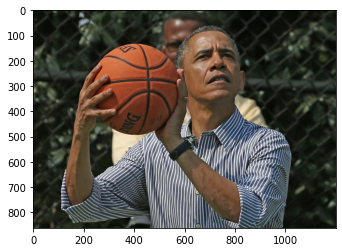

(1, 2048)
Caption: the man in the white shirt is playing the guitar
_____________________________________


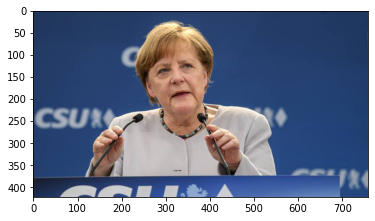

(1, 2048)
Caption: man in black shirt and glasses is holding cup
_____________________________________


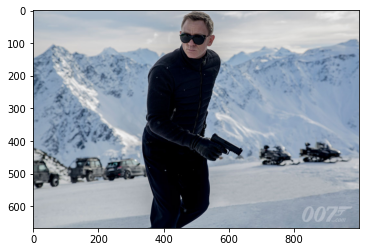

(1, 2048)
Caption: man in red jacket is standing on snowy mountain
_____________________________________


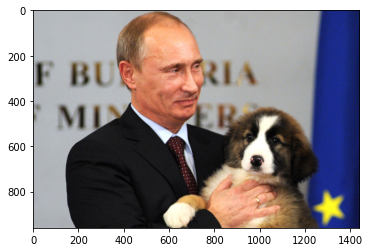

(1, 2048)
Caption: dog is running through the grass
_____________________________________


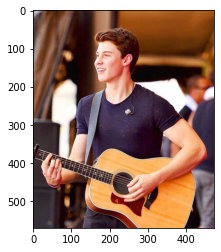

(1, 2048)
Caption: man in white shirt and tie is playing tennis
_____________________________________


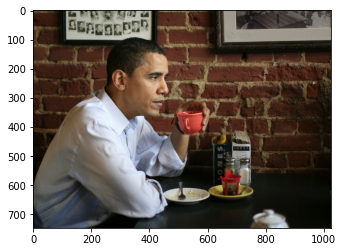

(1, 2048)
Caption: man in black shirt and tie is sitting on bench
_____________________________________


In [147]:
from PIL import Image, ImageFile
from matplotlib.pyplot import imshow
import requests
from io import BytesIO
import numpy as np

%matplotlib inline

paths = [
        '/content/drive/My Drive/captions/Bill_gates_reading.jpg',
        '/content/drive/My Drive/captions/Adam-Levine-Maroon-5-Girls-Like-You.jpg',
        '/content/drive/My Drive/captions/Crouch-Understanding-Obama-Basketball-1200.jpg',
        '/content/drive/My Drive/captions/angela-merkel-speech.jpg',
        '/content/drive/My Drive/captions/spectre-daniel-craig.jpg',
        '/content/drive/My Drive/captions/vladimir-putin-dog-george-w-bush.jpg',
        '/content/drive/My Drive/captions/Shawn_mendes.jpg',
        '/content/drive/My Drive/captions/Barack-Obama.jpg'
]

for path in paths:

  img = Image.open(path)
  img.load()

  plt.imshow(img)
  plt.show()
  


  img = encodeImage(img).reshape((1,OUTPUT_DIM))
  print(img.shape)
  print("Caption:",generateCaption(img))
  print("_____________________________________")